In [1]:
%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('../../src')

import pickle
from tuneable_counterfactuals_explainer.explainer import Explainer

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tuneable_counterfactuals_explainer.single_variable_explainer import SingleVariableExplainer

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline



from scipy.ndimage import gaussian_filter

from sklearn.svm import SVR

In [3]:
model = pickle.load(open('model/model.pkl', 'rb'))
training_data = pickle.load(open('model/training_data.pkl', 'rb'))

In [4]:
id=1

In [5]:
scores = gaussian_filter(
    (
        training_data.iloc[id].values[:-1].astype(float).reshape(28, 28)
    )/255, 
    sigma=5
).reshape(784)
dict_scores = {x:y for x,y in zip(training_data.columns[:-1], scores) if y>0.05}

In [6]:
explainer = Explainer(
    model,
    training_data,
    'target',
    regressor='linear',
    bounding_method='quantile',
    changeability_scores=dict_scores,
)

In [7]:
def plot_with_changes_highlighted(
    ax,
    original,
    result_object,
    model
):
    new = result_object[1].explanation_point
    new[result_object[1].explainable_variable] = result_object[1].get_arg_extrema()
    new = np.array(new).astype(np.float32)

    if type(original) is not np.ndarray:
        original = np.array(original).astype(np.float32)

    new_unchanged = new.copy()
    new_larger = new.copy()
    new_smaller = new.copy()
    
    new_unchanged[original != new] = np.nan # Only plot if it's the same
    new_larger[original >= new] = np.nan # Only plot if it's larger
    new_smaller[original <= new] = np.nan # Only plot if it's smaller

    ax.imshow(
        np.array(new_unchanged[:-1]).reshape(28, 28),
        cmap='binary',
    )

    ax.imshow(
        np.array(new_larger[:-1]).reshape(28, 28),
        cmap='Greens',
    )

    ax.imshow(
        np.array(new_smaller[:-1]).reshape(28, 28),
        cmap='Reds',
    )

    def highlight_cell(x, y, ax, color):
        ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, edgecolor=color, lw=2))
    
    for i in range(28):
        for j in range(28):
            if not np.isnan(new_larger[i * 28 + j]):
                highlight_cell(j, i, ax, 'g')
            if not np.isnan(new_smaller[i * 28 + j]):
                highlight_cell(j, i, ax, 'r')

    ax.set_xlabel(
        f'Classified as {model.predict(pd.DataFrame(new[:-1]).T)[0]} with\nprobability {model.predict_proba(pd.DataFrame(new[:-1]).T).max():.2f}',
        fontsize=36,
    )

    print(sum(original != new))
    return new



def plot_arrow(
    ax
):  
    ax.arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color='k')
    ax.set_ylim([0, 1])

In [8]:
result

NameError: name 'result' is not defined

In [8]:
result = result = explainer.explain(training_data.iloc[id], additional_threshold=0.499, store_historical_times=True)

 15%|█▍        | 113/764 [16:33<1:35:20,  8.79s/it]


In [9]:
initial_point = training_data.iloc[id][:-1]
initial_classification = int(model.predict(pd.DataFrame(initial_point).T))
working_point = initial_point.copy()
probabilities = [
    model.predict_proba(pd.DataFrame(initial_point).T)[:,1]
]
print(initial_point)
for feature in result[0]:
    sve = SingleVariableExplainer(
        model,
        'target',
        feature,
        working_point,
        training_dataset=training_data,
        regressor='linear',
        bounding_method='quantile',
    )
    working_point[feature] = sve.get_arg_extrema(initial_classification=initial_classification)
    probabilities.append(model.predict_proba(pd.DataFrame(working_point).T)[:,1])

/var/folders/qx/p1n3nbvn2j55yp0mkrpbgngr0000gn/T/ipykernel_7535/2829258988.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  initial_classification = int(model.predict(pd.DataFrame(initial_point).T))


pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Name: 39664, Length: 784, dtype: object


In [10]:
probabilities = [x[0] for x in probabilities]

In [11]:
step_time = pd.DataFrame(result[-1]).diff().values.flatten()

In [12]:
scores = result[-2]

In [13]:
def plot_with_changes_highlighted(
    ax,
    original,
    result_object,
    model
):
    new = result_object[1].explanation_point
    new[result_object[1].explainable_variable] = result_object[1].get_arg_extrema()
    new = np.array(new).astype(np.float32)

    if type(original) is not np.ndarray:
        original = np.array(original).astype(np.float32)

    new_unchanged = new.copy()
    new_larger = new.copy()
    new_smaller = new.copy()
    
    new_unchanged[original != new] = np.nan # Only plot if it's the same
    new_larger[original >= new] = np.nan # Only plot if it's larger
    new_smaller[original <= new] = np.nan # Only plot if it's smaller

    ax.imshow(
        np.array(new_unchanged[:-1]).reshape(28, 28),
        cmap='binary',
    )

    ax.imshow(
        np.array(new_larger[:-1]).reshape(28, 28),
        cmap='Greens',
    )

    ax.imshow(
        np.array(new_smaller[:-1]).reshape(28, 28),
        cmap='Reds',
    )

    def highlight_cell(x, y, ax, color):
        ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, edgecolor=color, lw=2))
    
    for i in range(28):
        for j in range(28):
            if not np.isnan(new_larger[i * 28 + j]):
                highlight_cell(j, i, ax, 'g')
            if not np.isnan(new_smaller[i * 28 + j]):
                highlight_cell(j, i, ax, 'r')

    ax.set_xlabel(
        f'Classified as {model.predict(pd.DataFrame(new[:-1]).T)[0]} with\nprobability {model.predict_proba(pd.DataFrame(new[:-1]).T).max():.2f}',
        fontsize=36,
    )

    print(sum(original != new))
    return new


def plot_arrow(
    ax
):  
    ax.arrow(x=0.25, y=0.5, dx=0.5, dy=0, width=0.1, color='k')
    ax.set_ylim([0, 1])

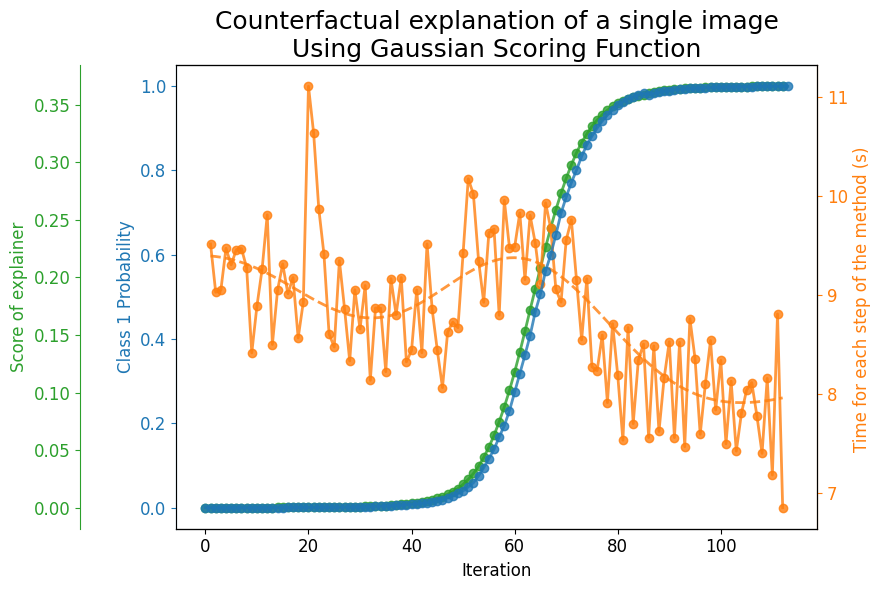

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(probabilities, 'o-', linewidth=2, markersize=6, color='C0', alpha=0.8)

twin_ax = ax.twinx()
twin_ax.plot(step_time, 'o-', linewidth=2, markersize=6, color='C1', alpha=0.8)

twin_ax_2 = ax.twinx()
twin_ax_2.plot(scores, 'o-', linewidth=2, markersize=6, color='C2', alpha=0.8)

twin_ax_2.spines["left"].set_position(("axes", -0.15))
twin_ax_2.spines["left"].set_visible(True)

twin_ax_2.yaxis.set_label_position('left')
twin_ax_2.yaxis.set_ticks_position('left')

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Class 1 Probability', fontsize=12)
twin_ax.set_ylabel('Time for each step of the method (s) ', fontsize=12)
twin_ax_2.set_ylabel('Score of explainer', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12)
twin_ax.tick_params(axis='both', which='major', labelsize=12)
twin_ax_2.tick_params(axis='both', which='major', labelsize=12)

fit_train_x = np.arange(len(step_time[1:]))
fit_train_y = step_time[1:]

gpr = SVR()
gpr.fit(fit_train_x.reshape(-1, 1), fit_train_y)
gpr_y_pred = gpr.predict(fit_train_x.reshape(-1, 1))

twin_ax.plot(fit_train_x+1, gpr_y_pred, '--', linewidth=2, color='C1', alpha=0.8)

twin_ax.spines['left'].set_color('C0')
twin_ax.spines['right'].set_color('C1')
ax.yaxis.label.set_color('C0')
ax.tick_params(axis='y', colors='C0')
twin_ax.yaxis.label.set_color('C1')
twin_ax.tick_params(axis='y', colors='C1')
twin_ax_2.spines['left'].set_color('C2')
twin_ax_2.yaxis.label.set_color('C2')
twin_ax_2.tick_params(axis='y', colors='C2')

ax.set_zorder(twin_ax_2.get_zorder()+2)
twin_ax.set_zorder(twin_ax_2.get_zorder()+1)
ax.set_facecolor('none')

ax.set_title('Counterfactual explanation of a single image\nUsing Gaussian Scoring Function', fontsize=18)
plt.tight_layout()

/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/joshanparmar/Development/TuneableCounterfactuals/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


113


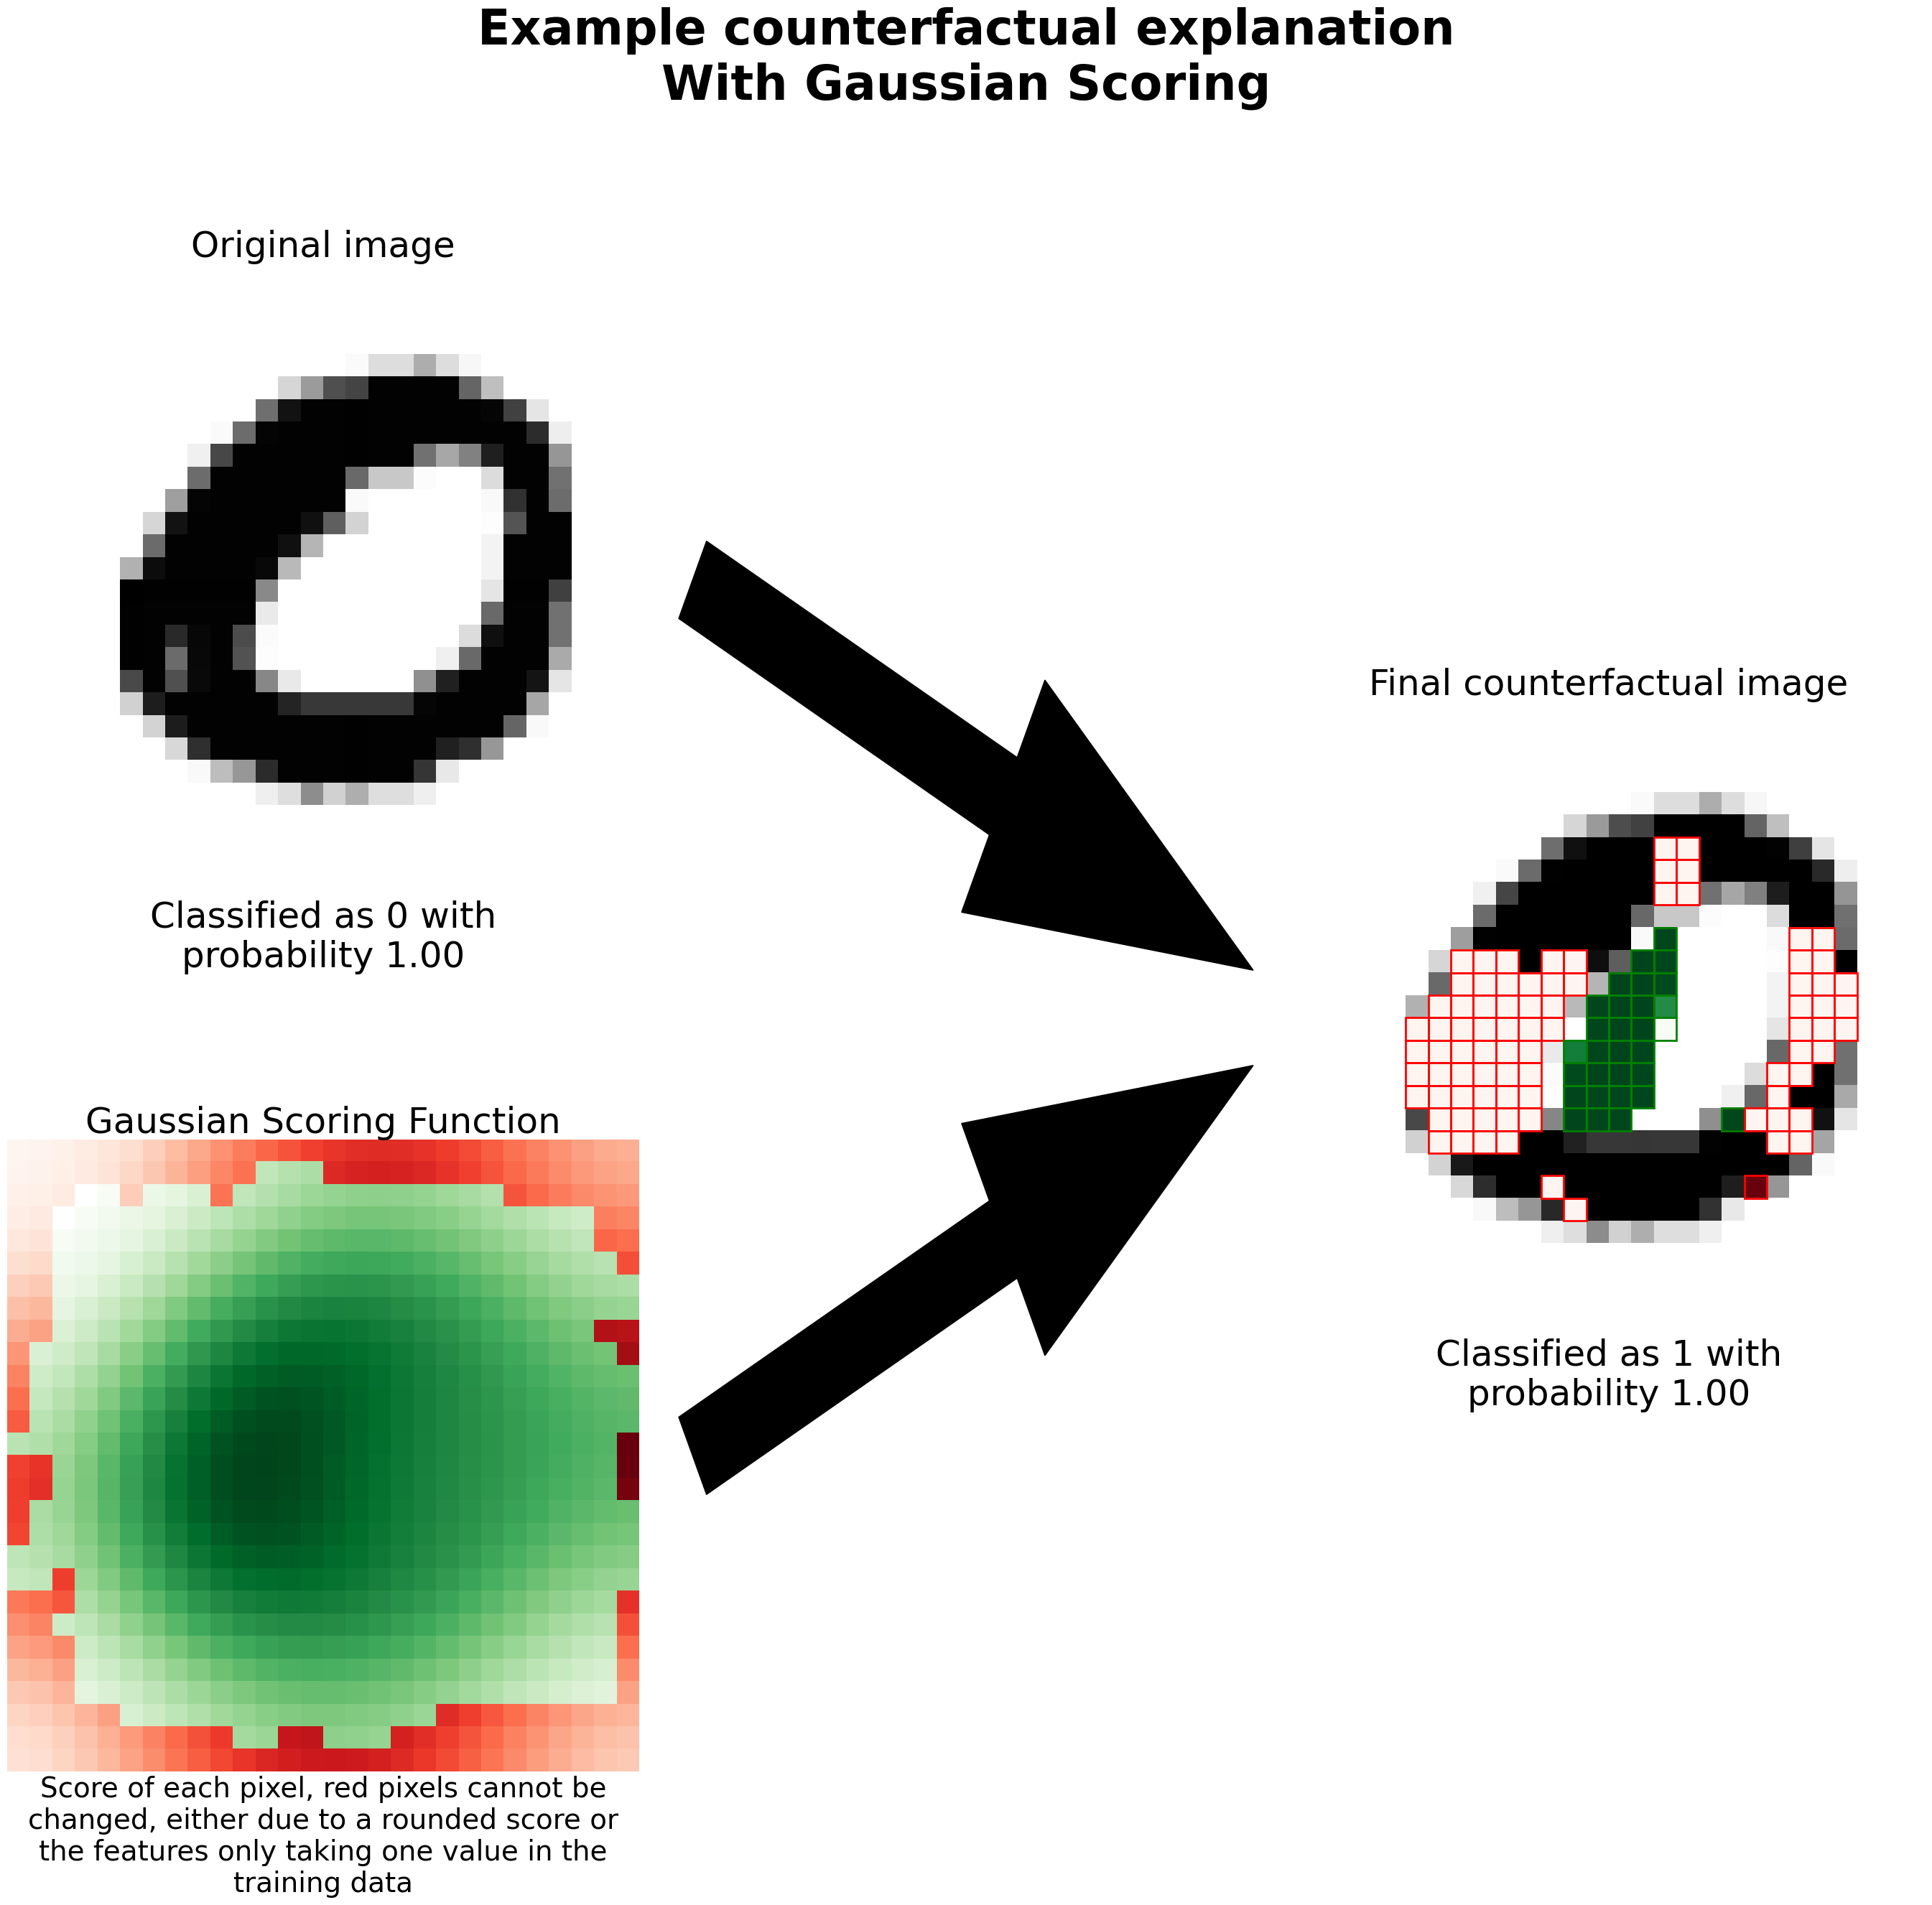

In [40]:
fig, ax = plt.subplots(2, 3, figsize=(27, 27))
ax[0,0].imshow(np.array(training_data.iloc[id][:-1]).astype(np.float32).reshape(28, 28), cmap='binary')
ax[0,0].set_title('Original image', fontsize=36)
ax[0,0].set_xlabel(
    f'Classified as {model.predict(pd.DataFrame(np.array(training_data.iloc[id]).astype(np.float32)[:-1]).T)[0]} with\nprobability {model.predict_proba(pd.DataFrame(np.array(training_data.iloc[id]).astype(np.float32)[:-1]).T).max():.2f}',
    fontsize=36,
)

blurred = gaussian_filter(
    np.array(training_data.iloc[id][:-1]).astype(np.float32).reshape(28, 28)/255, 
    sigma=5
)
red_blurred = blurred.copy()
blurred[blurred<=0.05] = np.nan
# red_blurred[red_blurred<=0.05] = 
blurred[((training_data.values.astype(float).max(axis=0) - training_data.values.astype(float).min(axis=0))==0)[:-1].reshape(28, 28)] = np.nan
red_blurred[((training_data.values.astype(float).max(axis=0) - training_data.values.astype(float).min(axis=0))!=0)[:-1].reshape(28, 28)] = np.nan
ax[1,0].imshow(
    blurred,
    cmap='Greens'
)
ax[1,0].imshow(
    red_blurred,
    cmap='Reds'
)
ax[1,0].set_title('Gaussian Scoring Function', fontsize=36)
ax[1,0].set_xlabel('Score of each pixel, red pixels cannot be\nchanged, either due to a rounded score or\nthe features only taking one value in the\ntraining data', fontsize=28)

gs = ax[1, 2].get_gridspec()
for a in ax[:, -1]:
    a.remove()
axbig = fig.add_subplot(gs[:, -1])

ax[1,1].arrow(x=0.25, y=0.5, dx=0.5, dy=0.25, width=0.1, color='k')
ax[1,1].set_ylim([0, 1])
ax[0,1].arrow(x=0.25, y=0.5, dx=0.5, dy=-0.25, width=0.1, color='k')
ax[0,1].set_ylim([0, 1])
_ =plot_with_changes_highlighted(axbig, training_data.iloc[id], result, model)
axbig.set_title('Final counterfactual image', fontsize=36)

for b in ax:
    for a in b:
        a.set_xticks([])
        a.set_yticks([])
        for spine in a.spines:
            a.spines[spine].set_visible(False)
for a in [axbig]:
    a.set_xticks([])
    a.set_yticks([])
    for spine in a.spines:
        a.spines[spine].set_visible(False)


plt.suptitle('Example counterfactual explanation\nWith Gaussian Scoring\n',weight='bold', fontsize=48)
plt.tight_layout()
plt.savefig('../../figures/overall_mnist_counterfactual_example.eps', bbox_inches='tight')
plt.savefig('../../figures/overall_mnist_counterfactual_example.png', bbox_inches='tight')